In [268]:
import sys

sys.path.append("../src/")
import mlflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mlflow.tracking import MlflowClient
from scipy.stats import pearsonr

client = MlflowClient(tracking_uri="http://localhost:5000")
experiment_id_mapping = experiment_id_mapping = {
    "cifar10-resnet": "206",
    "cifar100-resnet": "210",
    "mufac-resnet": "208",
    "cifar10-vit": "211",
    "cifar100-vit": "212",
    "mufac-vit": "213",
}

experiment_alpha_mapping = {
    "cifar10-resnet": "2.0",
    "cifar100-resnet": "2.0",
    "mufac-resnet": "2.0",
    "cifar10-vit": "2.0",
    "cifar100-vit": "2.0",
    "mufac-vit": "2.0",
}

def get_results(experiment_name):
    experiment_id = experiment_id_mapping[experiment_name]
    alpha = experiment_alpha_mapping[experiment_name]
    methods = [
        "original",
        "retrained",
        "finetune",
        "neggrad",
        "relabel",
        "badT",
        "scrub",
        "ssd",
        "unsir",
    ]
    metrics = ["mia", "acc_forget", "acc_retain", "acc_test", "acc_val", "t", "js", "js_proxy"]
    runs = client.search_runs(experiment_id)
    df = pd.DataFrame(
        [
            {k: v for k, v in run.data.metrics.items() if k in metrics}
            for run in runs
            if run.data.tags.get("mlflow.runName") in methods
            or (
                run.data.tags.get("mlflow.runName") == "our"
                and run.data.params.get("alpha") == str(alpha)
            )
        ]
    )
    df["method"] = [
        run.data.tags.get("mlflow.runName")
        for run in runs
        if run.data.tags.get("mlflow.runName") in methods
        or (
            run.data.tags.get("mlflow.runName") == "our"
            and run.data.params.get("alpha") == str(alpha)
        )
    ]

    df["seed"] = [
        run.data.params.get("seed")
        for run in runs
        if run.data.tags.get("mlflow.runName") in methods
        or (
            run.data.tags.get("mlflow.runName") == "our"
            and run.data.params.get("alpha") == str(alpha)
        )
    ]

    df.set_index(["method", "seed"], inplace=True)


    grouped_df = df.groupby("method").aggregate(["mean", "std"])
    grouped_df["js"] = grouped_df["js"].apply(lambda x: x * 1e4)
    grouped_df["js_proxy"] = grouped_df["js_proxy"].apply(lambda x: x * 1e4)
    grouped_df = grouped_df.round(2)

    gap_metrics = ["mia", "acc_forget", "acc_retain", "acc_test", "acc_val"]
    for method in [
        "finetune",
        "neggrad",
        "relabel",
        "badT",
        "scrub",
        "ssd",
        "unsir",
        "our",
        "retrained",
    ]:
        for metric in gap_metrics:
            grouped_df.loc[method, f"{metric}_gap"] = abs(
                grouped_df.loc[method, (metric, "mean")]
                - grouped_df.loc["retrained", (metric, "mean")]
            )
    grouped_df["avg_gap"] = (
        grouped_df[
            [
                "mia_gap",
                "acc_retain_gap",
                "acc_forget_gap",
                "acc_test_gap",
            ]
        ]
        .mean(axis=1)
        .round(4)
    )

    main_df = grouped_df.loc[
        ["finetune", "neggrad", "relabel", "badT", "scrub", "ssd", "unsir", "our"],
        ["avg_gap", "t", "js", "js_proxy"],
    ]
    appendix_df = grouped_df.loc[
        [
            "original",
            "retrained",
            "finetune",
            "neggrad",
            "relabel",
            "badT",
            "scrub",
            "ssd",
            "unsir",
            "our",
        ],
        [
            "mia",
            "mia_gap",
            "acc_forget",
            "acc_forget_gap",
            "acc_retain",
            "acc_retain_gap",
            "acc_test",
            "acc_test_gap",
            "avg_gap",
        ],
    ]

    print(experiment_name)
    corr, p_value = pearsonr(main_df[('avg_gap', '')], main_df[('js_proxy', 'mean')])
    print(f"Pearson correlation between avg_gap and js_proxy: {corr:.2f}, p-value: {p_value:.4f}")

    corr, p_value = pearsonr(main_df[('avg_gap', '')], main_df[('js', 'mean')])
    print(f"Pearson correlation between avg_gap and js: {corr:.2f}, p-value: {p_value:.4f}")

    corr, p_value = pearsonr(main_df[('js', 'mean')], main_df[('js_proxy', 'mean')])
    print(f"Pearson correlation between js and js_proxy: {corr:.2f}, p-value: {p_value:.4f}")
    display(main_df)
    display(appendix_df)

    return main_df, appendix_df

In [269]:
rn_cifar10, appendix_df = get_results("cifar10-resnet")

cifar10-resnet
Pearson correlation between avg_gap and js_proxy: 0.85, p-value: 0.0079
Pearson correlation between avg_gap and js: 0.95, p-value: 0.0003
Pearson correlation between js and js_proxy: 0.89, p-value: 0.0034


avg_gap     t         js       js_proxy        
                  mean  std  mean   std     mean     std
method                                                  
finetune  0.1375  0.43  0.0  1.03  0.24    81.45    6.53
neggrad   0.0975  0.49  0.0  1.06  0.21    80.64   21.01
relabel   0.0925  0.57  0.0  1.00  0.26    47.98    3.43
badT      0.2650  0.33  0.0  2.39  2.03   287.45  157.93
scrub     0.0750  0.58  0.0  0.41  0.09    62.39    5.54
ssd       0.0825  0.54  0.0  0.82  0.57   145.86  152.88
unsir     0.1075  0.45  0.0  0.65  0.05    17.29    4.21
our       0.0575  0.29  0.0  0.35  0.06    27.40    4.14

mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
           mean   std               mean   std                      mean   
method                                                                     
original   0.94  0.00     NaN       1.00  0.00            NaN       1.00   
retrained  0.76  0.03    0.00       0.91  0.02           0.00       0.99   
finetune   0.30  0.26    0.46       0.97  0.01           0.06       0.98   
neggrad    0.48  0.50    0.28       0.97  0.01           0.06       0.97   
relabel    0.48  0.50    0.28       0.96  0.01           0.05       0.97   
badT       0.43  0.37    0.33       0.71  0.18           0.20       0.71   
scrub      0.94  0.01    0.18       1.00  0.00           0.09       1.00   
ssd        0.81  0.11    0.05       0.86  0.16           0.05       0.87   
unsir      0.46  0.03    0.30       0.93  0.01           0.02       0.93   
our        0.90  0.01    0.14       1.00  0.01           0.09       0.99   

                acc_retain_gap acc_test       acc_test_gap avg_gap  
            std                    mean   std                       
method                                                              
original   0.00            NaN     0.93  0.01          NaN     NaN  
retrained  0.02           0.00     0.91  0.02         0.00  0.0000  
finetune   0.01           0.01     0.89  0.02         0.02  0.1375  
neggrad    0.01           0.02     0.88  0.02         0.03  0.0975  
relabel    0.01           0.02     0.89  0.02         0.02  0.0925  
badT       0.18           0.28     0.66  0.16         0.25  0.2650  
scrub      0.00           0.01     0.93  0.01         0.02  0.0750  
ssd        0.16           0.12     0.80  0.15         0.11  0.0825  
unsir      0.01           0.06     0.86  0.01         0.05  0.1075  
our        0.00           0.00     0.91  0.01         0.00  0.0575

In [270]:
rn_cifar100, appendix_df = get_results("cifar100-resnet")

cifar100-resnet
Pearson correlation between avg_gap and js_proxy: 0.80, p-value: 0.0164
Pearson correlation between avg_gap and js: 0.81, p-value: 0.0154
Pearson correlation between js and js_proxy: 0.99, p-value: 0.0000


avg_gap     t          js       js_proxy       
                  mean   std  mean   std     mean    std
method                                                  
finetune  0.3600  0.43  0.00  6.88  0.59   101.26  19.61
neggrad   0.3575  0.49  0.00  6.87  0.62   101.75  19.85
relabel   0.4025  0.57  0.00  5.84  0.98    74.93  20.53
badT      0.3675  0.34  0.01  4.30  0.49    63.04   8.91
scrub     0.1650  0.58  0.00  1.87  0.08    18.79   1.96
ssd       0.2125  0.54  0.00  3.04  1.55    42.17  36.59
unsir     0.3625  0.45  0.00  3.05  0.32    40.02   8.51
our       0.1025  0.30  0.01  1.29  0.03     8.35   0.19

mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
           mean   std               mean   std                      mean   
method                                                                     
original   0.77  0.05     NaN       0.93  0.04            NaN       0.93   
retrained  0.49  0.01    0.00       0.57  0.02           0.00       0.94   
finetune   0.00  0.00    0.49       0.40  0.06           0.17       0.41   
neggrad    0.00  0.00    0.49       0.41  0.06           0.16       0.41   
relabel    0.00  0.00    0.49       0.31  0.06           0.26       0.37   
badT       0.33  0.58    0.16       0.27  0.03           0.30       0.28   
scrub      0.78  0.05    0.29       0.93  0.03           0.36       0.93   
ssd        0.59  0.05    0.10       0.50  0.32           0.07       0.50   
unsir      0.00  0.00    0.49       0.40  0.07           0.17       0.41   
our        0.55  0.01    0.06       0.89  0.04           0.32       0.93   

                acc_retain_gap acc_test       acc_test_gap avg_gap  
            std                    mean   std                       
method                                                              
original   0.03            NaN     0.60  0.02          NaN     NaN  
retrained  0.03           0.00     0.60  0.02         0.00  0.0000  
finetune   0.06           0.53     0.35  0.05         0.25  0.3600  
neggrad    0.06           0.53     0.35  0.05         0.25  0.3575  
relabel    0.07           0.57     0.31  0.06         0.29  0.4025  
badT       0.03           0.66     0.25  0.03         0.35  0.3675  
scrub      0.03           0.01     0.60  0.02         0.00  0.1650  
ssd        0.32           0.44     0.36  0.20         0.24  0.2125  
unsir      0.07           0.53     0.34  0.04         0.26  0.3625  
our        0.03           0.01     0.62  0.01         0.02  0.1025

In [271]:
rn_mufac, appendix_df = get_results("mufac-resnet")

mufac-resnet
Pearson correlation between avg_gap and js_proxy: 0.30, p-value: 0.4686
Pearson correlation between avg_gap and js: 0.44, p-value: 0.2697
Pearson correlation between js and js_proxy: 0.97, p-value: 0.0000


avg_gap     t           js       js_proxy        
                  mean   std   mean   std     mean     std
method                                                    
finetune  0.1525  0.76  0.00  19.52  6.23  1439.18  233.65
neggrad   0.1550  0.91  0.00  19.16  5.31  1546.01  156.39
relabel   0.1300  1.06  0.00   9.51  2.39   444.89   73.01
badT      0.1025  0.66  0.00  10.31  1.56   456.88   57.50
scrub     0.1625  1.20  0.00  10.53  2.31   254.92  131.48
ssd       0.1600  1.07  0.00  10.30  2.28   243.30  142.87
unsir     0.1450  1.68  0.02  16.32  4.82   988.15  120.39
our       0.1250  0.62  0.00   6.90  1.49   133.11   45.89

mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
           mean   std               mean   std                      mean   
method                                                                     
original   0.70  0.06     NaN       0.88  0.04            NaN       0.89   
retrained  0.48  0.04    0.00       0.47  0.04           0.00       0.89   
finetune   0.54  0.09    0.06       0.64  0.04           0.17       0.64   
neggrad    0.53  0.08    0.05       0.68  0.04           0.21       0.66   
relabel    0.33  0.31    0.15       0.66  0.04           0.19       0.80   
badT       0.34  0.01    0.14       0.55  0.06           0.08       0.78   
scrub      0.70  0.05    0.22       0.88  0.06           0.41       0.89   
ssd        0.70  0.06    0.22       0.87  0.06           0.40       0.89   
unsir      0.40  0.35    0.08       0.71  0.03           0.24       0.73   
our        0.53  0.04    0.05       0.86  0.04           0.39       0.85   

                acc_retain_gap acc_test       acc_test_gap avg_gap  
            std                    mean   std                       
method                                                              
original   0.04            NaN     0.54  0.03          NaN     NaN  
retrained  0.04           0.00     0.56  0.02         0.00  0.0000  
finetune   0.04           0.25     0.43  0.01         0.13  0.1525  
neggrad    0.03           0.23     0.43  0.01         0.13  0.1550  
relabel    0.03           0.09     0.47  0.02         0.09  0.1300  
badT       0.05           0.11     0.48  0.02         0.08  0.1025  
scrub      0.04           0.00     0.54  0.03         0.02  0.1625  
ssd        0.05           0.00     0.54  0.03         0.02  0.1600  
unsir      0.03           0.16     0.46  0.01         0.10  0.1450  
our        0.08           0.04     0.54  0.05         0.02  0.1250

In [272]:
vit_cifar10, appendix_df = get_results("cifar10-vit")

cifar10-vit
Pearson correlation between avg_gap and js_proxy: 0.89, p-value: 0.0033
Pearson correlation between avg_gap and js: 0.98, p-value: 0.0000
Pearson correlation between js and js_proxy: 0.91, p-value: 0.0016


avg_gap      t          js       js_proxy      
                   mean   std  mean   std     mean   std
method                                                  
finetune  0.0075  11.33  0.03  0.01  0.00     3.26  0.68
neggrad   0.0125  12.61  0.03  0.03  0.00     6.12  0.25
relabel   0.0125  12.78  0.01  0.02  0.01     2.11  0.51
badT      0.0375   8.79  0.02  0.12  0.03     9.21  3.18
scrub     0.0050  16.66  0.02  0.01  0.00     2.81  0.20
ssd       0.0075  13.65  0.02  0.02  0.01     2.69  0.22
unsir     0.0100  10.68  0.02  0.01  0.01     2.41  0.66
our       0.0050   7.34  0.25  0.01  0.00     2.08  0.29

mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
           mean   std               mean   std                      mean   
method                                                                     
original   0.88  0.00     NaN       1.00  0.00            NaN       1.00   
retrained  0.88  0.01    0.00       0.99  0.00           0.00       1.00   
finetune   0.90  0.00    0.02       0.99  0.00           0.00       1.00   
neggrad    0.91  0.00    0.03       1.00  0.00           0.01       1.00   
relabel    0.84  0.02    0.04       0.99  0.00           0.00       1.00   
badT       0.81  0.02    0.07       0.96  0.01           0.03       0.97   
scrub      0.88  0.00    0.00       1.00  0.00           0.01       1.00   
ssd        0.89  0.01    0.01       1.00  0.01           0.01       1.00   
unsir      0.90  0.00    0.02       0.99  0.00           0.00       0.99   
our        0.87  0.00    0.01       1.00  0.00           0.01       1.00   

                acc_retain_gap acc_test       acc_test_gap avg_gap  
            std                    mean   std                       
method                                                              
original   0.00            NaN     0.99  0.01          NaN     NaN  
retrained  0.00           0.00     0.98  0.01         0.00  0.0000  
finetune   0.00           0.00     0.99  0.00         0.01  0.0075  
neggrad    0.00           0.00     0.99  0.01         0.01  0.0125  
relabel    0.00           0.00     0.99  0.01         0.01  0.0125  
badT       0.01           0.03     0.96  0.01         0.02  0.0375  
scrub      0.00           0.00     0.99  0.01         0.01  0.0050  
ssd        0.01           0.00     0.99  0.01         0.01  0.0075  
unsir      0.00           0.01     0.99  0.01         0.01  0.0100  
our        0.00           0.00     0.98  0.01         0.00  0.0050

In [273]:
vit_cifar100, appendix_df = get_results("cifar100-vit")

cifar100-vit
Pearson correlation between avg_gap and js_proxy: 0.92, p-value: 0.0011
Pearson correlation between avg_gap and js: 0.94, p-value: 0.0005
Pearson correlation between js and js_proxy: 0.92, p-value: 0.0013


avg_gap      t          js       js_proxy      
                   mean   std  mean   std     mean   std
method                                                  
finetune  0.0275  11.35  0.00  0.07  0.00     3.12  0.17
neggrad   0.0325  12.63  0.01  0.13  0.01     3.37  0.12
relabel   0.0175  12.79  0.02  0.06  0.00     2.74  0.17
badT      0.0375   9.18  0.27  0.17  0.01     3.80  0.22
scrub     0.0200  16.74  0.03  0.04  0.00     2.04  0.09
ssd       0.0175  13.67  0.02  0.04  0.00     2.08  0.13
unsir     0.0250  10.69  0.01  0.08  0.01     3.11  0.19
our       0.0125   7.02  0.01  0.03  0.00     1.89  0.07

mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
           mean   std               mean   std                      mean   
method                                                                     
original   0.75  0.00     NaN       0.97  0.01            NaN       0.96   
retrained  0.72  0.00    0.00       0.92  0.00           0.00       0.96   
finetune   0.77  0.00    0.05       0.95  0.01           0.03       0.98   
neggrad    0.79  0.02    0.07       0.97  0.02           0.05       0.97   
relabel    0.74  0.01    0.02       0.94  0.00           0.02       0.98   
badT       0.66  0.01    0.06       0.90  0.01           0.02       0.91   
scrub      0.75  0.00    0.03       0.97  0.00           0.05       0.96   
ssd        0.75  0.01    0.03       0.96  0.01           0.04       0.96   
unsir      0.78  0.01    0.06       0.94  0.00           0.02       0.95   
our        0.73  0.00    0.01       0.96  0.01           0.04       0.96   

                acc_retain_gap acc_test       acc_test_gap avg_gap  
            std                    mean   std                       
method                                                              
original   0.00            NaN     0.91  0.01          NaN     NaN  
retrained  0.00           0.00     0.91  0.00         0.00  0.0000  
finetune   0.00           0.02     0.92  0.01         0.01  0.0275  
neggrad    0.02           0.01     0.91  0.01         0.00  0.0325  
relabel    0.00           0.02     0.92  0.00         0.01  0.0175  
badT       0.00           0.05     0.89  0.01         0.02  0.0375  
scrub      0.00           0.00     0.91  0.01         0.00  0.0200  
ssd        0.00           0.00     0.91  0.00         0.00  0.0175  
unsir      0.01           0.01     0.90  0.01         0.01  0.0250  
our        0.00           0.00     0.91  0.00         0.00  0.0125

In [274]:
vit_mufac, appendix_df = get_results("mufac-vit")

mufac-vit
Pearson correlation between avg_gap and js_proxy: 0.98, p-value: 0.0000
Pearson correlation between avg_gap and js: 0.96, p-value: 0.0002
Pearson correlation between js and js_proxy: 0.94, p-value: 0.0006


avg_gap     t          js       js_proxy        
                  mean   std  mean   std     mean     std
method                                                   
finetune  0.0400  1.40  0.01  0.27  0.02    18.46    6.75
neggrad   0.0475  1.67  0.00  0.39  0.04    20.68    6.78
relabel   0.0200  1.76  0.01  0.35  0.09    22.58    3.92
badT      0.1750  2.09  0.25  1.89  1.01   201.41  191.09
scrub     0.0200  2.21  0.01  0.05  0.02     8.27    0.60
ssd       0.0200  1.91  0.00  0.17  0.17    14.89    9.32
unsir     0.0475  3.21  0.01  0.85  0.06    23.52    8.34
our       0.0200  1.09  0.00  0.05  0.01    10.11    0.54

mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
           mean   std               mean   std                      mean   
method                                                                     
original   0.58  0.01     NaN       0.63  0.01            NaN       0.66   
retrained  0.57  0.00    0.00       0.57  0.01           0.00       0.66   
finetune   0.52  0.08    0.05       0.61  0.01           0.04       0.72   
neggrad    0.52  0.07    0.05       0.66  0.02           0.09       0.71   
relabel    0.52  0.10    0.05       0.58  0.01           0.01       0.67   
badT       0.35  0.05    0.22       0.43  0.06           0.14       0.47   
scrub      0.59  0.01    0.02       0.62  0.01           0.05       0.66   
ssd        0.59  0.01    0.02       0.59  0.04           0.02       0.63   
unsir      0.47  0.08    0.10       0.58  0.01           0.01       0.72   
our        0.59  0.01    0.02       0.63  0.00           0.06       0.66   

                acc_retain_gap acc_test       acc_test_gap avg_gap  
            std                    mean   std                       
method                                                              
original   0.01            NaN     0.66  0.01          NaN     NaN  
retrained  0.01           0.00     0.65  0.01         0.00  0.0000  
finetune   0.01           0.06     0.66  0.01         0.01  0.0400  
neggrad    0.01           0.05     0.65  0.03         0.00  0.0475  
relabel    0.02           0.01     0.64  0.01         0.01  0.0200  
badT       0.07           0.19     0.50  0.08         0.15  0.1750  
scrub      0.01           0.00     0.66  0.01         0.01  0.0200  
ssd        0.04           0.03     0.64  0.01         0.01  0.0200  
unsir      0.01           0.06     0.63  0.02         0.02  0.0475  
our        0.01           0.00     0.65  0.01         0.00  0.0200

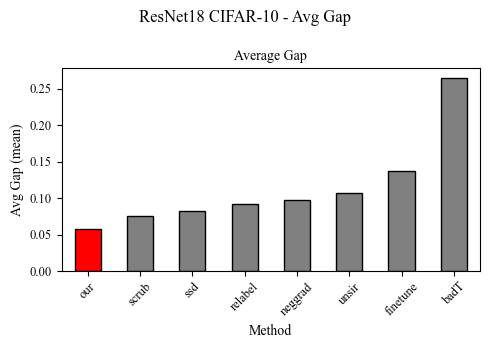

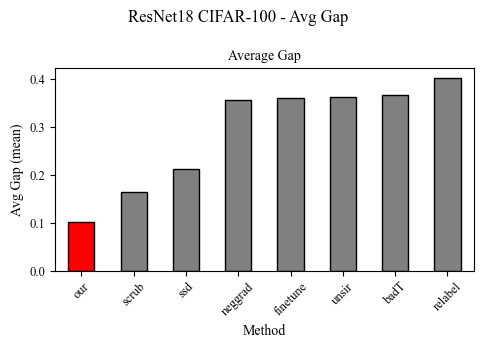

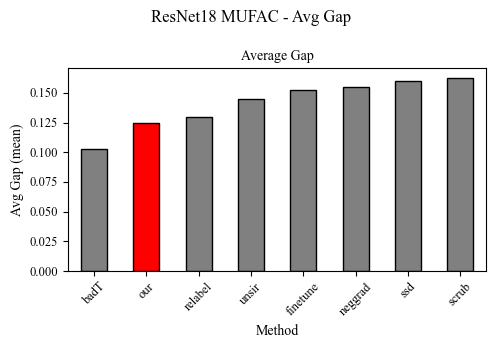

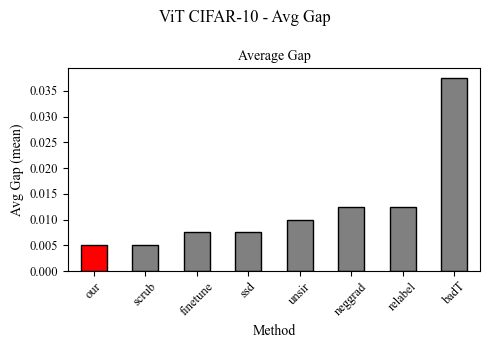

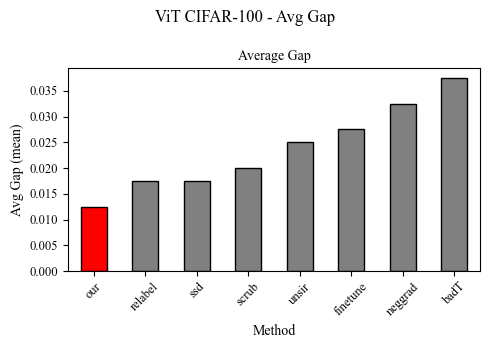

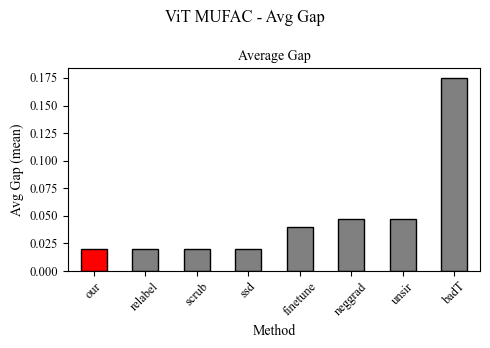

In [285]:
def plot_avg_gap(df, title):
    df_sorted = df.sort_values(by=("avg_gap", ""), ascending=True)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    fig.suptitle(title, fontsize=12, fontname="Times New Roman")

    # Sort by value
    df_sorted = df.sort_values(
        by=("avg_gap", ""),
        ascending=True,
        key=lambda x: x.where(df.index != "our", x - 0.0001),
    )
    # Define colors for the bars
    colors = ["red" if method == "our" else "gray" for method in df_sorted.index]

    df_sorted[("avg_gap", "")].plot(kind="bar", ax=ax, color=colors, edgecolor="black")
    ax.set_title("Average Gap", fontsize=10, fontname="Times New Roman")
    ax.set_xlabel("Method", fontsize=10, fontname="Times New Roman")
    ax.set_ylabel("Avg Gap (mean)", fontsize=10, fontname="Times New Roman")
    ax.tick_params(axis="x", rotation=45, labelsize=9)
    ax.tick_params(axis="y", labelsize=9)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname("Times New Roman")

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()


# Plot avg_gap for each dataframe
plot_avg_gap(rn_cifar10, "ResNet18 CIFAR-10 - Avg Gap")
plot_avg_gap(rn_cifar100, "ResNet18 CIFAR-100 - Avg Gap")
plot_avg_gap(rn_mufac, "ResNet18 MUFAC - Avg Gap")
plot_avg_gap(vit_cifar10, "ViT CIFAR-10 - Avg Gap")
plot_avg_gap(vit_cifar100, "ViT CIFAR-100 - Avg Gap")
plot_avg_gap(vit_mufac, "ViT MUFAC - Avg Gap")

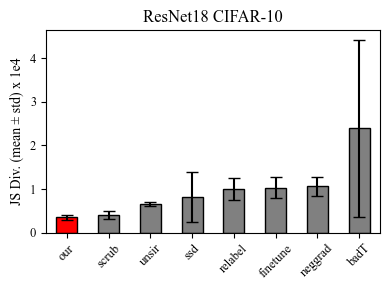

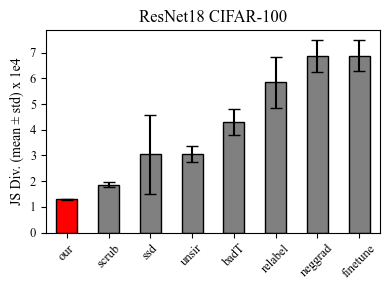

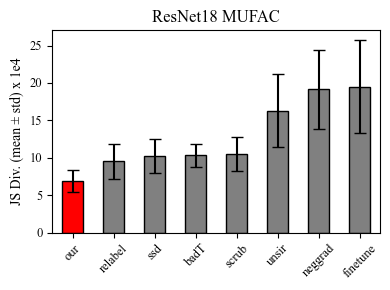

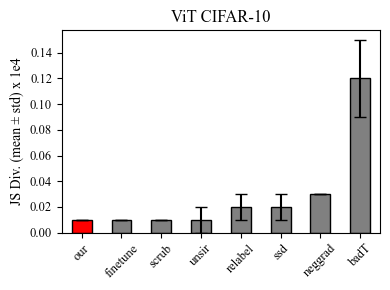

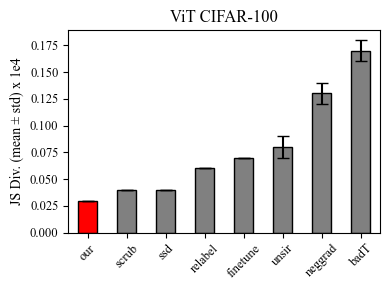

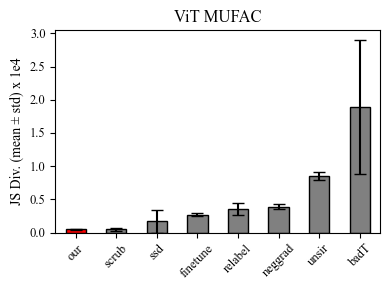

In [283]:
def plot_js_divergence(df, title):
    df_sorted_js = df.sort_values(by=('js', 'mean'), ascending=True, key=lambda x: x.where(df.index != 'our', x - 0.0001))
    
    fig, ax = plt.subplots(figsize=(4, 3))

    # Define colors for the bars
    colors_js = ['red' if method == 'our' else 'gray' for method in df_sorted_js.index]

    # Plot js
    df_sorted_js[('js', 'mean')].plot(kind='bar', yerr=df_sorted_js[('js', 'std')], ax=ax, color=colors_js, edgecolor='black', capsize=4)
    ax.set_title(title, fontsize=12, fontname='Times New Roman')
    ax.set_xlabel(None)
    ax.set_ylabel('JS Div. (mean ± std) x 1e4', fontsize=10, fontname='Times New Roman')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Times New Roman')

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f'images/{title}_js_divergence.png', bbox_inches='tight', dpi=300)
    plt.show()

# Plot JS divergence for each dataframe
plot_js_divergence(rn_cifar10, "ResNet18 CIFAR-10")
plot_js_divergence(rn_cifar100, "ResNet18 CIFAR-100")
plot_js_divergence(rn_mufac, "ResNet18 MUFAC")
plot_js_divergence(vit_cifar10, "ViT CIFAR-10")
plot_js_divergence(vit_cifar100, "ViT CIFAR-100")
plot_js_divergence(vit_mufac, "ViT MUFAC")

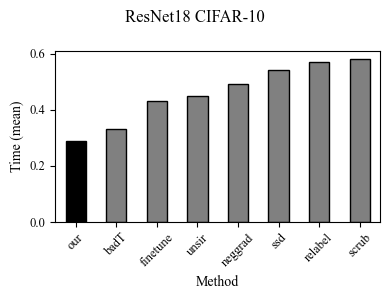

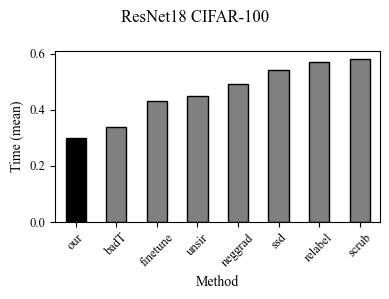

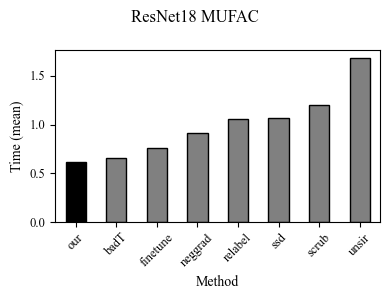

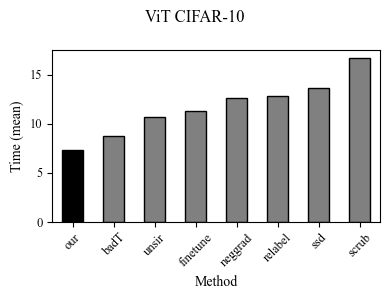

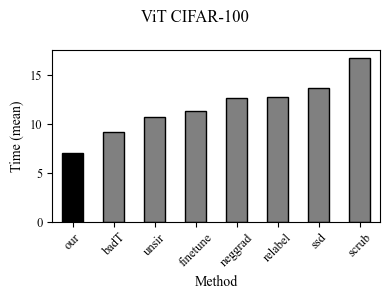

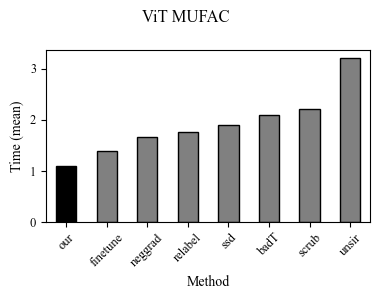

In [284]:
def plot_time(df, title):
    df_sorted = df.sort_values(by=("t", "mean"), ascending=True)

    fig, ax = plt.subplots(figsize=(4, 3))
    fig.suptitle(title, fontsize=12, fontname="Times New Roman")

    # Sort by value
    df_sorted = df.sort_values(
        by=("t", "mean"),
        ascending=True,
        key=lambda x: x.where(df.index != "our", x - 0.0001),
    )
    # Define colors for the bars
    colors = ["black" if method == "our" else "grey" for method in df_sorted.index]

    df_sorted[("t", "mean")].plot(kind="bar", ax=ax, color=colors, edgecolor="black")
    # ax.set_title("Time (mean)", fontsize=10, fontname="Times New Roman")
    ax.set_xlabel("Method", fontsize=10, fontname="Times New Roman")
    ax.set_ylabel("Time (mean)", fontsize=10, fontname="Times New Roman")
    ax.tick_params(axis="x", rotation=45, labelsize=9)
    ax.tick_params(axis="y", labelsize=9)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname("Times New Roman")

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()


# Plot (t, mean) for each dataframe
plot_time(rn_cifar10, "ResNet18 CIFAR-10")
plot_time(rn_cifar100, "ResNet18 CIFAR-100")
plot_time(rn_mufac, "ResNet18 MUFAC")
plot_time(vit_cifar10, "ViT CIFAR-10")
plot_time(vit_cifar100, "ViT CIFAR-100")
plot_time(vit_mufac, "ViT MUFAC")